In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ship-exhaust/scikitlearn/default/1/ship_emission_lgbm_minimal.pkl
/kaggle/input/ship-data-full-details/Ship_Data_Full_Details.csv
/kaggle/input/ship-data-full-details/final_emissions_with_base.csv
/kaggle/input/ship-data-full-details/data_ship_emissions.csv
/kaggle/input/ship-data-full-details/Ship_Data.csv
/kaggle/input/ship-data-full-details/Ship_emissions.csv


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error
import joblib

In [3]:
file_path = '/kaggle/input/ship-data-full-details/final_emissions_with_base.csv'
df = pd.read_csv(file_path)
df.head()

,month,type,year_ship,buoy,time_port,time_anchor,time_trip,time_maneuver,v_trip,v_maneuver,...,E2_CH4,E3_CH4,E4_CH4,E5_CH4,Total_CH4,E1_base_CH4,E2_base_CH4,E3_base_CH4,E4_base_CH4,E5_base_CH4
0,7,container_ship,1994,0,212.16,208,0.24,3.92,9.87,7.72,...,281.165835,1.222512,73.726866,3912.037762,4304.126854,35.973880,281.165835,1.222512,73.726866,3912.037762
1,12,container_ship,2022,0,33.47,29,0.24,4.23,9.87,7.15,...,408.619947,1.847464,120.227269,824.253145,1415.932929,60.985104,408.619947,1.847464,120.227269,824.253145
2,6,container_ship,1990,0,233.44,229,0.25,4.19,9.42,7.22,...,390.028779,2.019389,124.966014,6829.884795,7398.583887,51.684909,390.028779,2.019389,124.966014,6829.884795
3,7,container_ship,2007,0,59.59,55,0.25,4.34,9.63,6.97,...,256.154004,1.280474,82.076431,1040.139106,1418.566352,38.916337,256.154004,1.280474,82.076431,1040.139106
4,7,container_ship,2021,0,126.21,122,0.25,3.96,9.54,7.65,...,235.471537,1.608914,94.099172,2899.014907,3257.855709,38.959407,318.204780,1.608914,94.099172,2899.014907


In [4]:
feature_cols = [
    # 'type', 
    'year_ship', 'rpm', 'is_man', 'valve_type',
    'P_main', 'P_aux',
    'v_trip', 'v_maneuver', 'v_max',
    'time_anchor' 
]
target_cols = [col for col in df.columns if col not in feature_cols 
               and col not in ['buoy', 'time_port', 'time_trip', 'time_maneuver', 'month', 'type']
               # and 'base' not in col 
              ]

print(f"Input Features: {len(feature_cols)}")
print(f"   List: {feature_cols}")

X = df[feature_cols].copy()
y = df[target_cols].copy()
# y = y.drop(columns=['CO2_scaled'])


Input Features: 10
   List: ['year_ship', 'rpm', 'is_man', 'valve_type', 'P_main', 'P_aux', 'v_trip', 'v_maneuver', 'v_max', 'time_anchor']


In [5]:
y.columns

Index(['E1_PM10', 'E2_PM10', 'E3_PM10', 'E4_PM10', 'E5_PM10', 'Total_PM10',
       'E1_base_PM10', 'E2_base_PM10', 'E3_base_PM10', 'E4_base_PM10',
       'E5_base_PM10', 'E1_PM2.5', 'E2_PM2.5', 'E3_PM2.5', 'E4_PM2.5',
       'E5_PM2.5', 'Total_PM2.5', 'E1_base_PM2.5', 'E2_base_PM2.5',
       'E3_base_PM2.5', 'E4_base_PM2.5', 'E5_base_PM2.5', 'E1_NOx', 'E2_NOx',
       'E3_NOx', 'E4_NOx', 'E5_NOx', 'Total_NOx', 'E1_base_NOx', 'E2_base_NOx',
       'E3_base_NOx', 'E4_base_NOx', 'E5_base_NOx', 'E1_SOx', 'E2_SOx',
       'E3_SOx', 'E4_SOx', 'E5_SOx', 'Total_SOx', 'E1_base_SOx', 'E2_base_SOx',
       'E3_base_SOx', 'E4_base_SOx', 'E5_base_SOx', 'E1_CO', 'E2_CO', 'E3_CO',
       'E4_CO', 'E5_CO', 'Total_CO', 'E1_base_CO', 'E2_base_CO', 'E3_base_CO',
       'E4_base_CO', 'E5_base_CO', 'E1_HC', 'E2_HC', 'E3_HC', 'E4_HC', 'E5_HC',
       'Total_HC', 'E1_base_HC', 'E2_base_HC', 'E3_base_HC', 'E4_base_HC',
       'E5_base_HC', 'E1_CO2', 'E2_CO2', 'E3_CO2', 'E4_CO2', 'E5_CO2',
       'Total_CO2', 

In [6]:
encoders = {}

le_type = LabelEncoder()
# X['type'] = le_type.fit_transform(X['type'].astype(str))
# encoders['type'] = le_type

le_valve = LabelEncoder()
X['valve_type'] = le_valve.fit_transform(X['valve_type'].astype(str))
encoders['valve_type'] = le_valve

X['is_man'] = X['is_man'].astype(int)

cat_features = [
    # 'type', 
                'valve_type', 'is_man']
for col in cat_features:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test_base = train_test_split(X, y, test_size=0.2, random_state=42)
y_train=y_train[[col for col in y_train.columns if 'base' not in col]]


In [7]:
y_test=y_test_base[[col for col in y_test_base.columns if 'base' not in col]]
y_test.columns

Index(['E1_PM10', 'E2_PM10', 'E3_PM10', 'E4_PM10', 'E5_PM10', 'Total_PM10',
       'E1_PM2.5', 'E2_PM2.5', 'E3_PM2.5', 'E4_PM2.5', 'E5_PM2.5',
       'Total_PM2.5', 'E1_NOx', 'E2_NOx', 'E3_NOx', 'E4_NOx', 'E5_NOx',
       'Total_NOx', 'E1_SOx', 'E2_SOx', 'E3_SOx', 'E4_SOx', 'E5_SOx',
       'Total_SOx', 'E1_CO', 'E2_CO', 'E3_CO', 'E4_CO', 'E5_CO', 'Total_CO',
       'E1_HC', 'E2_HC', 'E3_HC', 'E4_HC', 'E5_HC', 'Total_HC', 'E1_CO2',
       'E2_CO2', 'E3_CO2', 'E4_CO2', 'E5_CO2', 'Total_CO2', 'E1_N2O', 'E2_N2O',
       'E3_N2O', 'E4_N2O', 'E5_N2O', 'Total_N2O', 'E1_CH4', 'E2_CH4', 'E3_CH4',
       'E4_CH4', 'E5_CH4', 'Total_CH4'],
      dtype='object')

In [11]:
y_train.columns

Index(['E1_PM10', 'E2_PM10', 'E3_PM10', 'E4_PM10', 'E5_PM10', 'Total_PM10',
       'E1_PM2.5', 'E2_PM2.5', 'E3_PM2.5', 'E4_PM2.5', 'E5_PM2.5',
       'Total_PM2.5', 'E1_NOx', 'E2_NOx', 'E3_NOx', 'E4_NOx', 'E5_NOx',
       'Total_NOx', 'E1_SOx', 'E2_SOx', 'E3_SOx', 'E4_SOx', 'E5_SOx',
       'Total_SOx', 'E1_CO', 'E2_CO', 'E3_CO', 'E4_CO', 'E5_CO', 'Total_CO',
       'E1_HC', 'E2_HC', 'E3_HC', 'E4_HC', 'E5_HC', 'Total_HC', 'E1_CO2',
       'E2_CO2', 'E3_CO2', 'E4_CO2', 'E5_CO2', 'Total_CO2', 'E1_N2O', 'E2_N2O',
       'E3_N2O', 'E4_N2O', 'E5_N2O', 'Total_N2O', 'E1_CH4', 'E2_CH4', 'E3_CH4',
       'E4_CH4', 'E5_CH4', 'Total_CH4'],
      dtype='object')

1. Vẽ biểu đồ Monthly CO2...


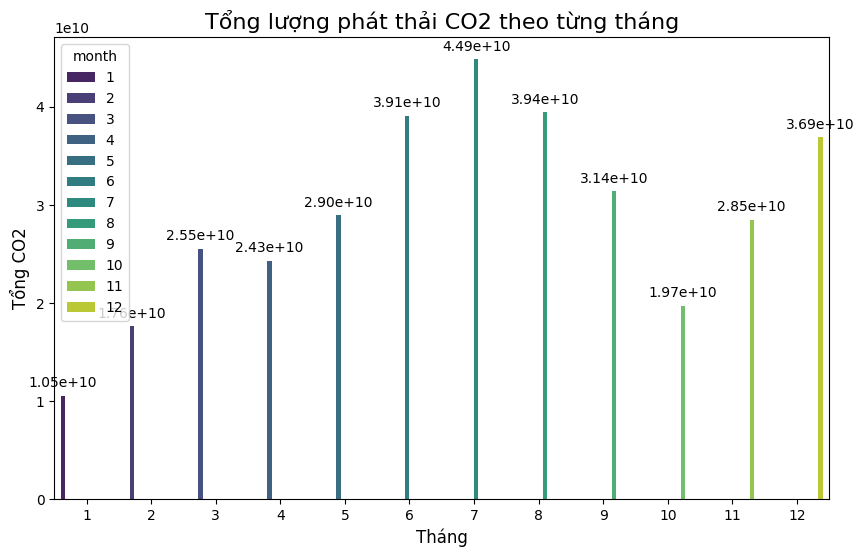


2. Thống kê mô tả...
--- THỐNG KÊ CƠ BẢN ---
                   mean           std           min           50%  \
P_main     3.531741e+04  1.383752e+04  1.082674e+04  3.511461e+04   
rpm        1.145285e+02  9.512212e+00  9.290000e+01  1.138000e+02   
v_trip     1.002906e+01  5.078394e-01  8.320000e+00  1.003000e+01   
Total_CO2  4.998165e+08  3.086162e+08  3.701307e+07  4.402329e+08   
Total_NOx  7.106812e+06  5.791258e+06  2.160182e+05  5.701736e+06   

                    max      skew  
P_main     6.463074e+04  0.055541  
rpm        1.370000e+02  0.111725  
v_trip     1.155000e+01 -0.085216  
Total_CO2  1.572932e+09  0.799894  
Total_NOx  2.684714e+07  0.988943  

3. Vẽ Heatmap...


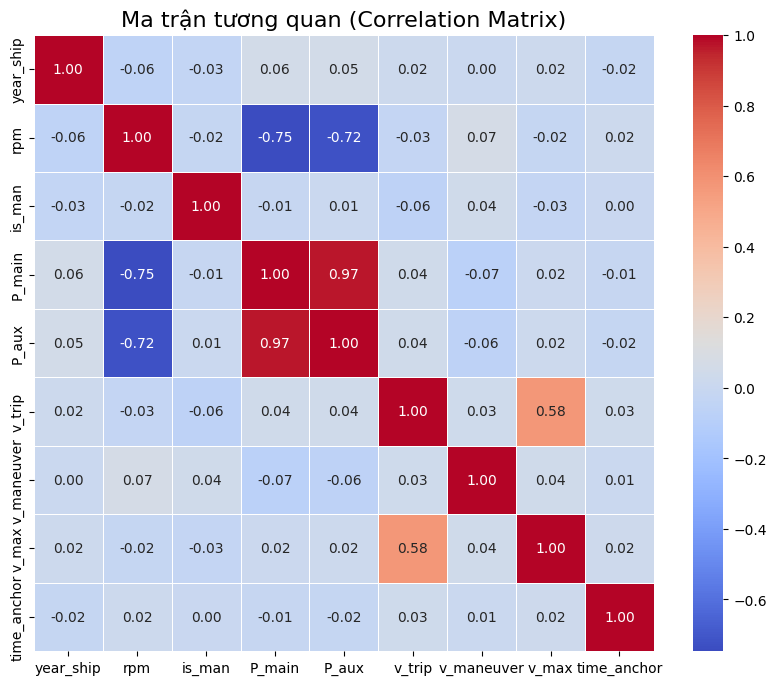


4. Khai phá dữ liệu cho ML...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


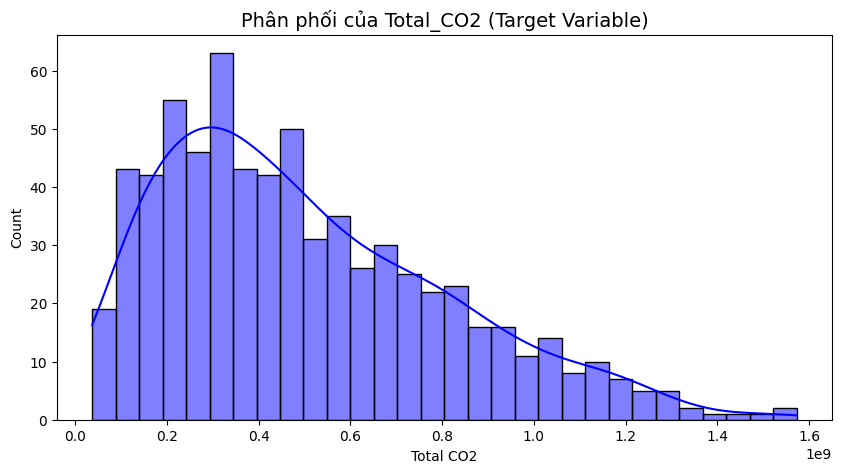

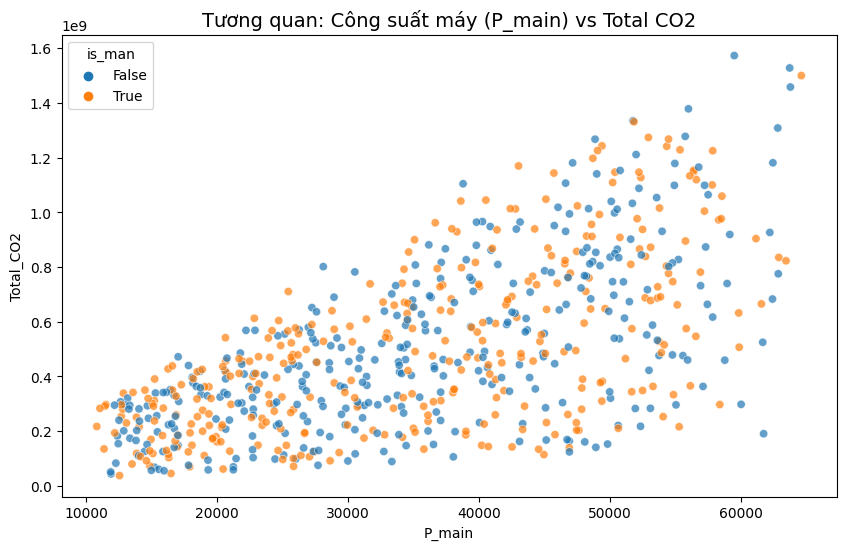

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


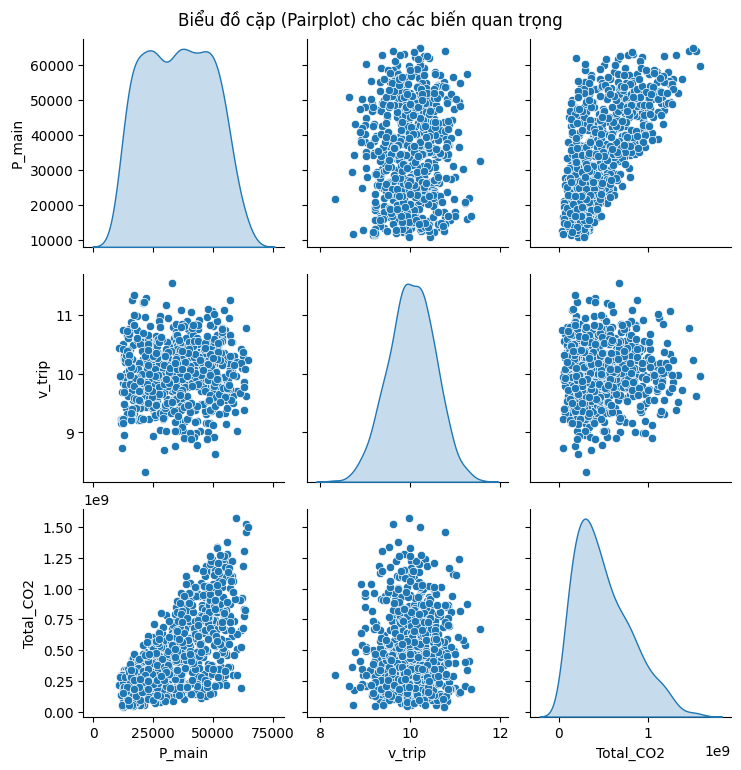

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_monthly_co2(df):
    monthly_co2 = df.groupby('month')['Total_CO2'].sum().reset_index()
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='month', y='Total_CO2', data=monthly_co2, palette='viridis', hue='month')
    
    plt.title('Tổng lượng phát thải CO2 theo từng tháng', fontsize=16)
    plt.xlabel('Tháng', fontsize=12)
    plt.ylabel('Tổng CO2', fontsize=12)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2e}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    plt.show()

def print_statistics(df):
    print("--- THỐNG KÊ CƠ BẢN ---")
    cols = ['P_main', 'rpm', 'v_trip', 'Total_CO2', 'Total_NOx']
    stats = df[cols].describe().T
    
    stats['skew'] = df[cols].skew()
    stats['kurtosis'] = df[cols].kurt()
    
    print(stats[['mean', 'std', 'min', '50%', 'max', 'skew']])

def plot_heatmap(df):
    focus_cols = [  'year_ship', 'rpm', 'is_man',
    'P_main', 'P_aux',
    'v_trip', 'v_maneuver', 'v_max',
    'time_anchor']
    
    valid_cols = [c for c in focus_cols if c in df.columns]
    
    corr_matrix = df[valid_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Ma trận tương quan (Correlation Matrix)', fontsize=16)
    plt.show()

def ml_exploration(df):
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Total_CO2'], kde=True, color='blue', bins=30)
    plt.title('Phân phối của Total_CO2 (Target Variable)', fontsize=14)
    plt.xlabel('Total CO2')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='P_main', y='Total_CO2', data=df, hue='is_man', alpha=0.7)
    plt.title('Tương quan: Công suất máy (P_main) vs Total CO2', fontsize=14)
    plt.show()

    subset = df[['P_main', 'v_trip', 'Total_CO2']]
    sns.pairplot(subset, diag_kind='kde')
    plt.suptitle("Biểu đồ cặp (Pairplot) cho các biến quan trọng", y=1.02)
    plt.show()

if __name__ == "__main__":
    print("1. Vẽ biểu đồ Monthly CO2...")
    plot_monthly_co2(df)
    
    print("\n2. Thống kê mô tả...")
    print_statistics(df)
    
    print("\n3. Vẽ Heatmap...")
    plot_heatmap(df)
    
    print("\n4. Khai phá dữ liệu cho ML...")
    ml_exploration(df)

In [9]:

print("Start")

lgbm = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

model = MultiOutputRegressor(lgbm)
model.fit(X_train, y_train)
print("Done!")

Start
Done!


In [10]:
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np

print("Đang đánh giá mô hình trên tập Test...")
y_pred = model.predict(X_test)

metrics_list = []

for i, col_name in enumerate(target_cols):
    
    y_true_col = y_test.iloc[:, i]
    y_pred_col = y_pred[:, i]
    
    mae = mean_absolute_error(y_true_col, y_pred_col)
    r2 = r2_score(y_true_col, y_pred_col)
    
    mape = np.mean(np.abs((y_true_col - y_pred_col) / (y_true_col + 1e-9))) * 100
    
    mean_val = y_true_col.mean()

    metrics_list.append({
        'Target': col_name,
        'R2 Score': r2,
        'MAE (Đơn vị gốc)': mae,
        'Mean Value (Quy mô)': mean_val,
        'Sai số % (MAPE)': mape
    })

metrics_df = pd.DataFrame(metrics_list)

metrics_df = metrics_df.sort_values(by='Sai số % (MAPE)', ascending=False)

# --- IN KẾT QUẢ ---
print("\n" + "="*60)
print("BÁO CÁO ĐÁNH GIÁ CHI TIẾT TỪNG CHẤT Ô NHIỄM")
print("="*60)


avg_r2 = metrics_df['R2 Score'].mean()
avg_mape = metrics_df['Sai số % (MAPE)'].mean()
print(f"ĐỘ CHÍNH XÁC TRUNG BÌNH (R2): {avg_r2:.5f}")
print(f"SAI SỐ TRUNG BÌNH TOÀN BỘ (MAPE): {avg_mape:.4f}%")
print("-" * 60)

print("\nTOP 10 CỘT CÓ SAI SỐ CAO NHẤT:")
print(metrics_df[['Target', 'Sai số % (MAPE)', 'MAE (Đơn vị gốc)', 'R2 Score']].head(10).to_string(index=False))

print("-" * 60)

print("\nTOP 5 CỘT DỰ ĐOÁN CHÍNH XÁC NHẤT:")
print(metrics_df[['Target', 'Sai số % (MAPE)', 'R2 Score']].tail(5).to_string(index=False))


metrics_df.to_csv('evaluation_report.csv', index=False)
print(f"\nĐã lưu bảng đánh giá chi tiết vào 'evaluation_report.csv'")

Đang đánh giá mô hình trên tập Test...


IndexError: single positional indexer is out-of-bounds

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np

print("Đang đánh giá mô hình trên tập Test...")
y_pred = model.predict(X_test)

y_test=y_test_base[[col for col in y_test_base.columns if 'base' in col]]
y_test.columns = y_test.columns.str.replace('base_', '')

metrics_list = []

for i, col_name in enumerate(target_cols):
    
    y_true_col = y_test.iloc[:, i]
    y_pred_col = y_pred[:, i]
    
    mae = mean_absolute_error(y_true_col, y_pred_col)
    r2 = r2_score(y_true_col, y_pred_col)
    
    mape = np.mean(np.abs((y_true_col - y_pred_col) / (y_true_col + 1e-9))) * 100
    
    mean_val = y_true_col.mean()

    metrics_list.append({
        'Target': col_name,
        'R2 Score': r2,
        'MAE (Đơn vị gốc)': mae,
        'Mean Value (Quy mô)': mean_val,
        'Sai số % (MAPE)': mape
    })

metrics_df = pd.DataFrame(metrics_list)

metrics_df = metrics_df.sort_values(by='Sai số % (MAPE)', ascending=False)

# --- IN KẾT QUẢ ---
print("\n" + "="*60)
print("BÁO CÁO ĐÁNH GIÁ CHI TIẾT TỪNG CHẤT Ô NHIỄM")
print("="*60)


avg_r2 = metrics_df['R2 Score'].mean()
avg_mape = metrics_df['Sai số % (MAPE)'].mean()
print(f"ĐỘ CHÍNH XÁC TRUNG BÌNH (R2): {avg_r2:.5f}")
print(f"SAI SỐ TRUNG BÌNH TOÀN BỘ (MAPE): {avg_mape:.4f}%")
print("-" * 60)

print("\nTOP 10 CỘT CÓ SAI SỐ CAO NHẤT:")
print(metrics_df[['Target', 'Sai số % (MAPE)', 'MAE (Đơn vị gốc)', 'R2 Score']].head(10).to_string(index=False))

print("-" * 60)

print("\nTOP 5 CỘT DỰ ĐOÁN CHÍNH XÁC NHẤT:")
print(metrics_df[['Target', 'Sai số % (MAPE)', 'R2 Score']].tail(5).to_string(index=False))


metrics_df.to_csv('evaluation_report.csv', index=False)
print(f"\nĐã lưu bảng đánh giá chi tiết vào 'evaluation_report.csv'")

In [ ]:
model_filename = '/kaggle/working/ship_emission_lgbm_minimal.pkl'
save_obj = {
    'model': model,
    'encoders': encoders,
    'feature_cols': feature_cols, 
    'target_cols': target_cols,
    'cat_features': cat_features
}
joblib.dump(save_obj, model_filename)
print(f"\nĐã lưu model tại: {model_filename}")

In [ ]:
def infer_ship_emissions(input_data, model_path='/kaggle/working/ship_emission_lgbm_minimal.pkl'):
    """
    Hàm dự đoán phát thải tàu biển từ dữ liệu đầu vào thô.
    
    Args:
        input_data (list or pd.DataFrame): Dữ liệu đầu vào (list of lists hoặc DataFrame).
        model_path (str): Đường dẫn đến file model (.pkl).
        
    Returns:
        pd.DataFrame: DataFrame chứa thông tin tàu và các cột phát thải dự đoán.
    """
    
    col_names = [
        'year_ship', 'buoy', 
        'time_port', 'time_anchor', 'time_trip', 'time_maneuver', 
        'v_trip', 'v_maneuver', 'v_max', 
        'P_main', 'P_aux', 
        'is_man', 'valve_type', 'rpm'
    ]
    
    if isinstance(input_data, list):
        df_new = pd.DataFrame(input_data, columns=col_names)
    elif isinstance(input_data, pd.DataFrame):
        df_new = input_data.copy()
    else:
        raise ValueError("input_data phải là list hoặc pandas DataFrame")


    df_display = df_new.copy()


    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Không tìm thấy file model tại: {model_path}")
    
    try:
        loaded_data = joblib.load(model_path)
        print(f"Đã load mô hình thành công.")
    except Exception as e:
        raise Exception(f"Lỗi khi load file pickle: {e}")

    model = loaded_data['model']
    feature_cols = loaded_data['feature_cols']
    print(feature_cols)
    target_cols = loaded_data['target_cols']
    
    encoders = loaded_data.get('encoders', {})
    if not encoders and 'le_valve' in loaded_data:
        encoders = {
            # 'type': loaded_data['le_type'],
            'valve_type': loaded_data['le_valve']
        }

    print("Đang xử lý dữ liệu...")


    df_new['is_man'] = df_new['is_man'].astype(str).apply(
        lambda x: 1 if x.upper() == 'TRUE' or x == '1' else 0
    ).astype(int)

    for col, encoder in encoders.items():
        if col in df_new.columns:
            df_new[col] = encoder.transform(df_new[col].astype(str))

    cat_features = ['type', 'valve_type', 'is_man']
    for col in cat_features:
        if col in df_new.columns:
            df_new[col] = df_new[col].astype('category')

    try:
        X_input = df_new[feature_cols]
    except KeyError as e:
        raise KeyError(f"Dữ liệu đầu vào thiếu cột: {e}")

    print("🚀 Đang chạy dự đoán...")
    preds = model.predict(X_input)

    df_results = pd.DataFrame(preds, columns=target_cols)
    
    final_output = pd.concat([
        df_display[['year_ship', 'P_main']], 
        df_results
    ], axis=1)

    return final_output




In [ ]:
test_input = [
    [
        1994, 0, 
        214.04, 208, 0.24, 5.8, 
        9.87, 5.22, 13, 
        24017.07965, 4803.394908, 
        'FALSE', 'C3', 113.6
    ],
    [
        2022, 0, 
        35.75, 29, 0.24, 6.51, 
        9.87, 4.65, 14, 
        40965.12535, 8193.046379, 
        'FALSE', 'SV', 106.4
    ]
]

MODEL_FILE = '/kaggle/working/ship_emission_lgbm_minimal.pkl'

try:
    predictions = infer_ship_emissions(test_input, model_path=MODEL_FILE)

    print("\n--- KẾT QUẢ DỰ ĐOÁN TỪ MODEL ---")
    important_cols = ['year_ship', 'Total_NOx', 'Total_SOx', 'Total_CO2', 'Total_PM10']
    print(predictions[important_cols].to_string(index=False))
    
except Exception as e:
    print(f"Có lỗi xảy ra: {e}")